In [49]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_cv
import os
import IPython.display as display

In [50]:
dataset_location = '/mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/Food ingredient recognition.v4i.tfrecord'
tfrecord_name = "food-ingredient.tfrecord"
print(os.path.exists(dataset_location))

True


In [51]:
dataset_train = tf.data.TFRecordDataset(dataset_location + f"/train/{tfrecord_name}")
print(dataset_train)

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


In [52]:
result = {}
for raw_record in dataset_train.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    for key, feature in example.features.feature.items():
        kind = feature.WhichOneof('kind')
        result[key] = np.array(getattr(feature, kind).value)

2024-05-30 11:23:19.500977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [53]:
for key, value in result.items():
    print(key, value)

image/object/bbox/ymin [0.25961539 0.28846154 0.32211539]
image/width [416]
image/object/bbox/xmax [0.34615386 0.70192307 0.99759614]
image/encoded [b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01\xa0\x01\xa0\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92

In [63]:
feature_description = {
    'image/object/bbox/ymin' : tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmin' : tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax' : tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax' : tf.io.VarLenFeature(tf.float32),
    'image/object/class/text' : tf.io.VarLenFeature(tf.string),
    'image/object/class/label' : tf.io.VarLenFeature(tf.int64),
    'image/encoded' : tf.io.FixedLenFeature([], tf.string),
    'image/format' : tf.io.FixedLenFeature([], tf.string),
    'image/filename' : tf.io.FixedLenFeature([], tf.string),
    'image/height' : tf.io.FixedLenFeature([], tf.int64),
    'image/width' : tf.io.FixedLenFeature([], tf.int64)
}
def _parse_function(example_proto):
    return tf.io.parse_single_example(example_proto, feature_description)

In [64]:
parsed_dataset = dataset_train.map(_parse_function)

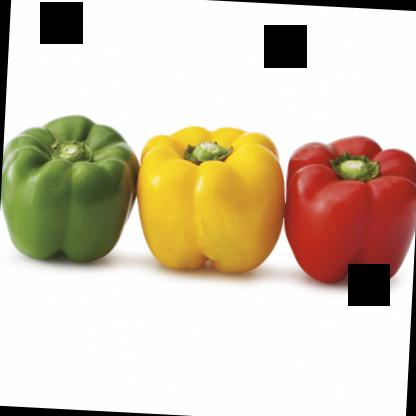

SparseTensor(indices=tf.Tensor(
[[0]
 [1]
 [2]], shape=(3, 1), dtype=int64), values=tf.Tensor([0.         0.3125     0.68028843], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3], shape=(1,), dtype=int64))


2024-05-30 11:28:36.338727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [71]:
for image_features in parsed_dataset.take(1):
    image_raw = image_features['image/encoded'].numpy()
    display.display(display.Image(data=image_raw))
    print(image_features['image/object/bbox/xmin'])